In [135]:
import sys
sys.path.insert(0,'/home/zahradnik/PycharmProjects/master_thesis')

In [136]:
from src.modules import conf, fit, evl, preprocess
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor, XGBRFRegressor
warnings.simplefilter("ignore")
from feature_engine.creation import MathFeatures

In [137]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [24, 8]
plt.rcParams['figure.dpi']

100.0

In [139]:
data = fit.load_pcls(
        'zahradnik',
        'running',
        conf["Paths"]["pcl"],
    )

100%|██████████| 386/386 [00:00<00:00, 1630.70it/s]


In [140]:
low_dist, high_dist = preprocess.segment_data(data)
len(low_dist),len(high_dist)

(144, 242)

In [141]:
test_df = preprocess.load_test_activity(path="tracks/bechovice.gpx",
                                        race_day ='2023-10-21-11-30')
print(len(test_df))

2122


In [142]:
if max(test_df.distance) > 10000:
    train_df = fit.clean_data(pd.concat(high_dist))
else:
    train_df = fit.clean_data(pd.concat(low_dist))
len(train_df)

681291

In [143]:
len(train_df.columns),len(test_df.columns)

(134, 60)

In [144]:
len(train_df),len(test_df)

(681291, 2122)

In [145]:
len(train_df[test_df.columns].columns),len(test_df.columns)

(60, 60)

# Cadence

In [146]:
clf = XGBRegressor()

In [147]:
clf.fit(train_df[test_df.columns], train_df.cadence)
test_df['cadence'] = clf.predict(test_df)
test_df['cadence'].mean()

92.230644

In [148]:
test_df= preprocess.calc_windows(df=test_df,
          lagged=15,
          cols=["cadence"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="cadence")

# Heart Rate

In [149]:
clf.fit(train_df[test_df.columns], train_df.heart_rate)
test_df["heart_rate"] = clf.predict(test_df)
test_df["heart_rate"].mean()

177.94373

In [150]:
for fce in ["sum", "mean", "min", "max"]:
    test_df = MathFeatures(variables=["heart_rate", "cadence"], func=fce).fit(test_df).transform(test_df)

In [151]:
test_df= preprocess.calc_windows(df=test_df,
          lagged=12,
          cols=["heart_rate"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="heart_rate")

In [152]:
clf.fit(train_df[test_df.columns], train_df.enhanced_speed)
y_pred_ridge = clf.predict(test_df)

In [153]:
percent_delay = int(len(test_df) * 0.02)  ## 2% delay

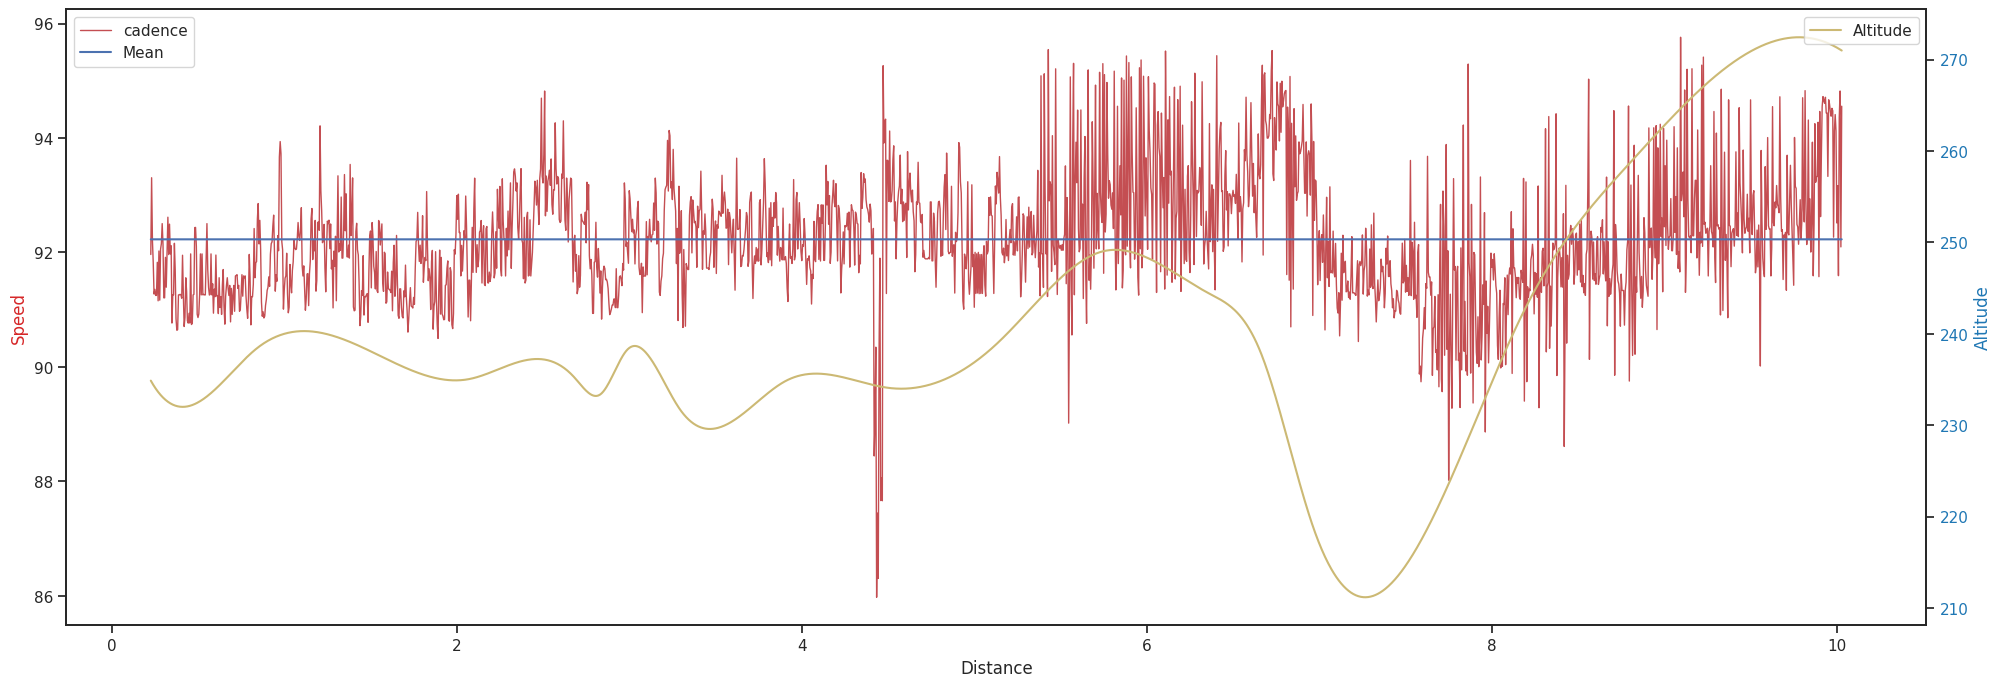

In [154]:
_, _ = evl.plot(df=test_df[percent_delay:],pred=test_df['cadence'][percent_delay:],endog = "cadence")

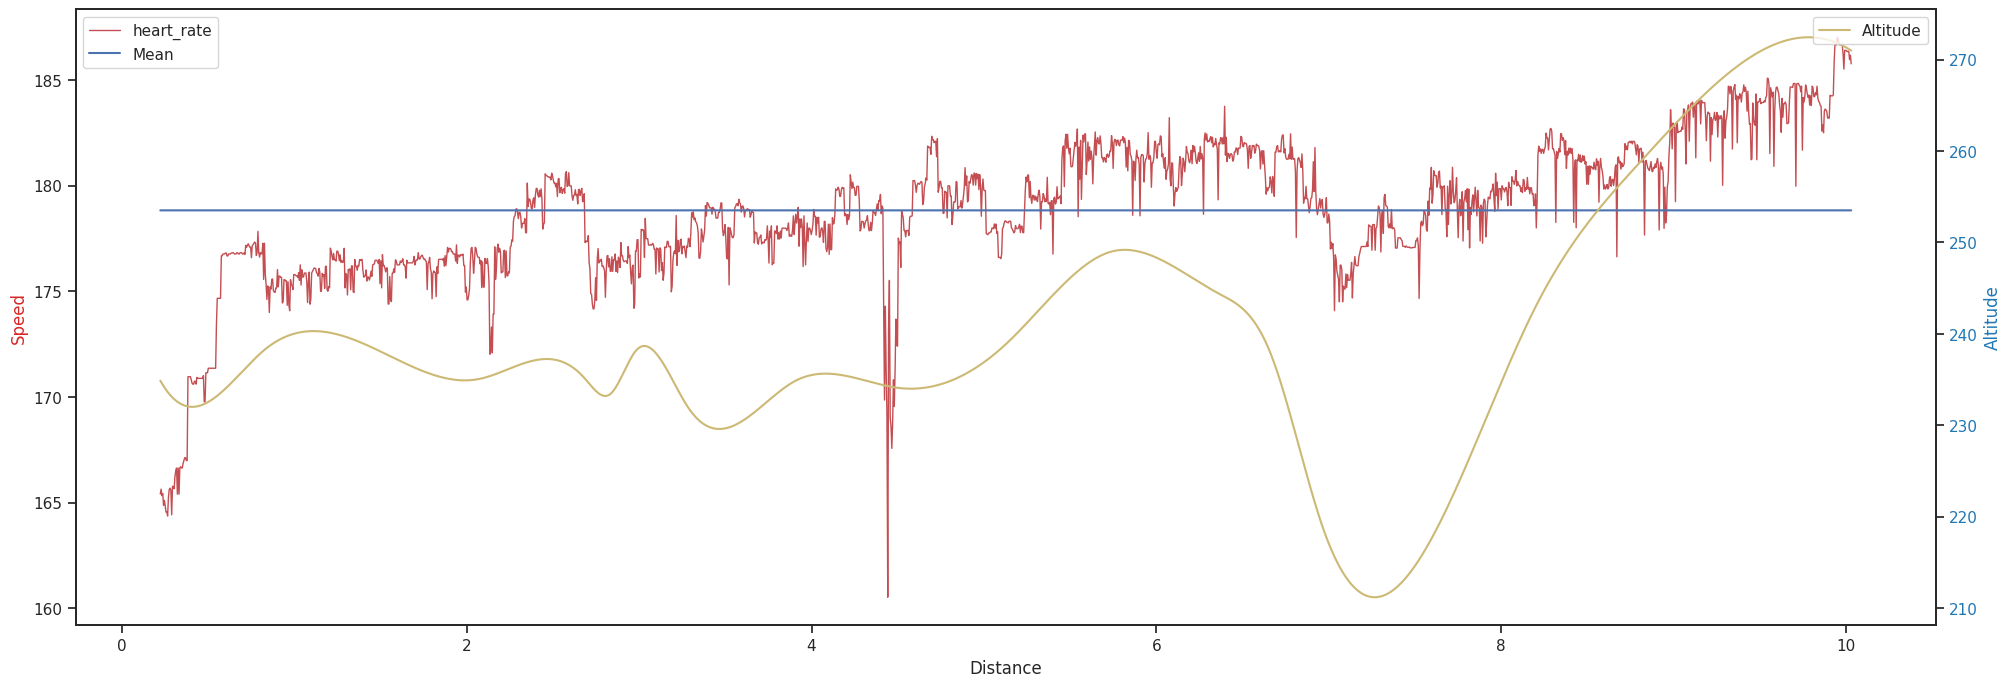

In [155]:
_, _ = evl.plot(df=test_df[percent_delay:],pred=test_df['heart_rate'][percent_delay:],endog = "heart_rate")

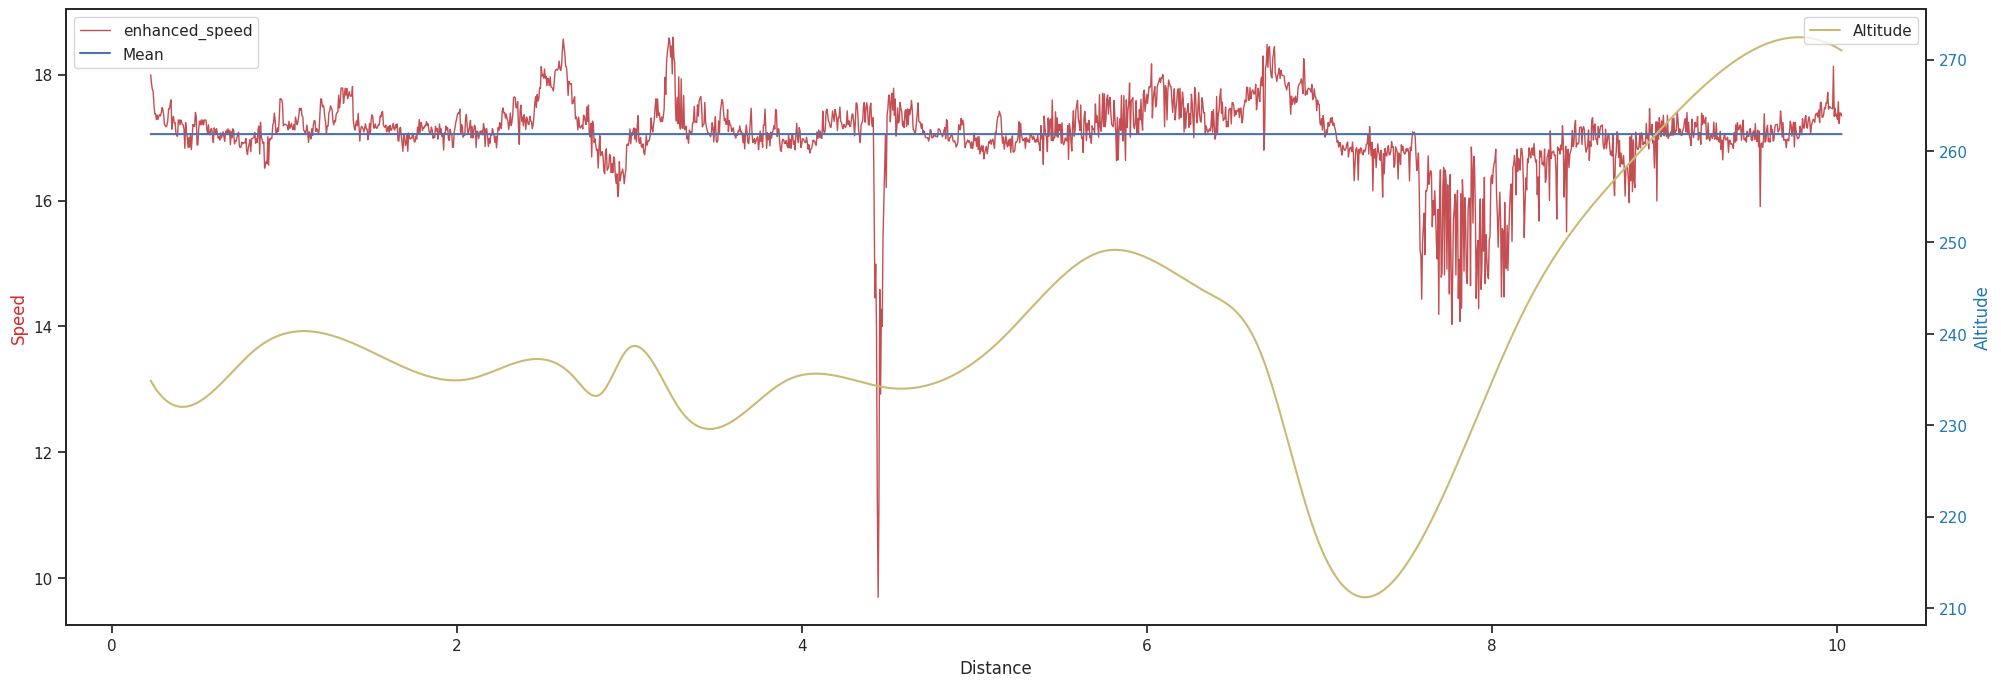

In [156]:
_, _ = evl.plot(df=test_df[percent_delay:],pred=y_pred_ridge[percent_delay:],endog = "enhanced_speed")

In [157]:
np.mean(test_df.cadence), np.mean(test_df.heart_rate),np.mean(y_pred_ridge)

(92.230644, 177.94373, 17.045336)

In [158]:
y_pred_ridge = [x if x > 15 else np.mean(y_pred_ridge) or x if x < 30 else np.mean(y_pred_ridge) for x in y_pred_ridge]

In [159]:
import math

# np.mean(speed_test), np.mean(y_pred_ridge), max(test_df.distance)
time = ((np.max(test_df.distance) / 1000) / np.mean(y_pred_ridge)) * 60
minutes = math.floor(time)
seconds = round((time - minutes) * 60)
if seconds == 60:
    seconds=0
    minutes+=1
f'Final time: {minutes}:{seconds}'

'Final time: 35:11'

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

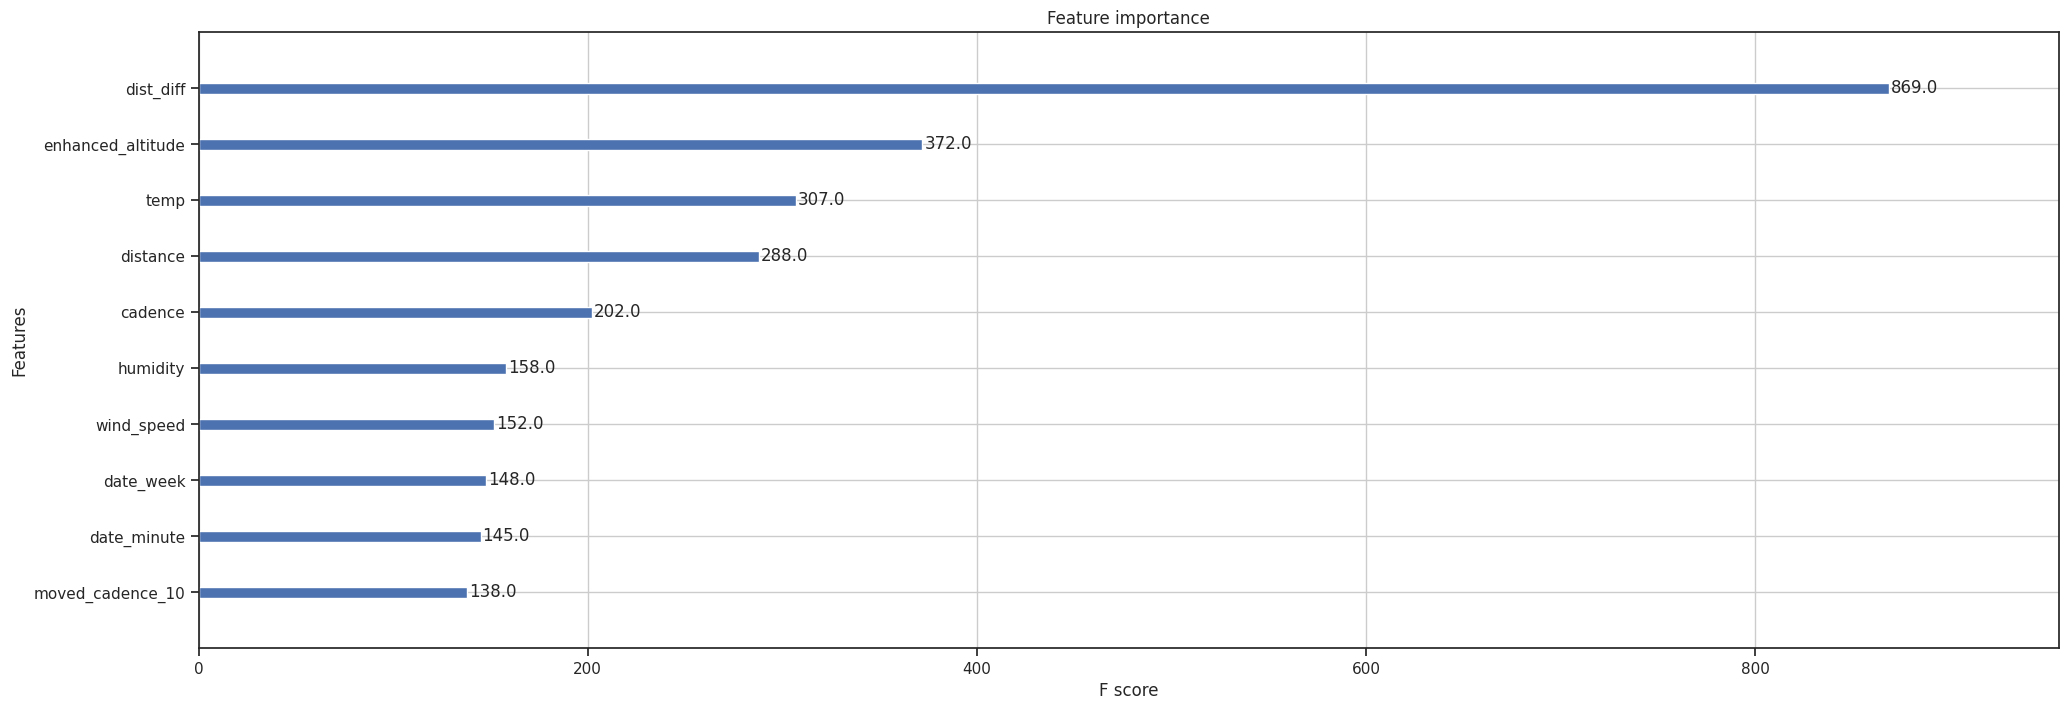

In [160]:
import xgboost as xgb
xgb.plot_importance(clf, max_num_features=10)  # Adjust max_num_features as needed